# COMP0123 Complex Networks and Webs Coursework 1

Importing libraries

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

## Task 0 - Preparation of Network Data

- Among the millions of authors, firstly you extract all authors whose research interests are related to 'social network', including those with interests in 'Social network', 'social networks', 'human social network' etc.

In [2]:
# Creating our graph
G = nx.Graph()

In [53]:
# Retrieving indices of all author's who have an interest in 'social networks'
author_indices = []
interest = "social network"

with open("data/AMiner-Author.txt", 'r', encoding='utf-8') as f:
    current_author_index = None
    for line in f:
        line = line.strip()

        if line.startswith("#index"):
            current_author_index = line.split(' ')[1]
        
        if line.startswith("#t"):
            interests = line[2:]
            # Check if any variant of the interest is in the author's interests.
            if interest in interests.lower():
                author_indices.append(current_author_index)

In [54]:
# Adding all author indices to the graph
G.add_nodes_from(author_indices)
G.number_of_nodes()

9219

- Secondly, you extract all links (co-authorships) among the above authors. You should discard any authors with degree 0 (that have no link with any of the other authors) and any repeated links, so that you create a simple graph.

In [55]:
# Adding in edges
edges = []

with open("data/AMiner-Coauthor.txt", 'r') as f:
    for line in f:
    
        author1, author2, _ = line.split()
        author1 = author1[1:]
        
        if (author1 in author_indices) and (author2 in author_indices):
            edges.append([author1, author2])
        

In [56]:
G.add_edges_from(edges)
G.number_of_edges()

12129

In [57]:
# Removing nodes with degree 0
F = nx.Graph()                                                                                                                                     
fedges = filter(lambda x: G.degree()[x[0]] > 0 and G.degree()[x[1]] > 0, G.edges())
F.add_edges_from(fedges)

In [59]:
F.number_of_nodes()

7829

In [60]:
F.number_of_edges()

12129

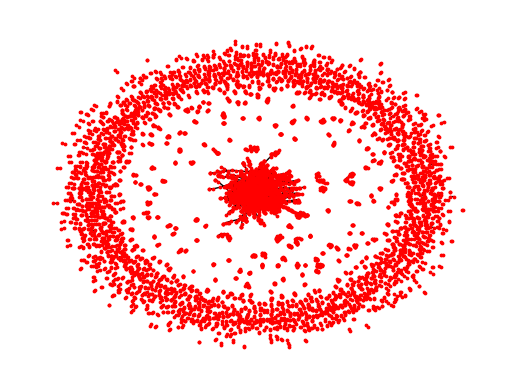

In [63]:
subax1 = plt.subplot()
options = {

    'node_color': 'red',

    'node_size': 3,

    'width': 1,

}
nx.draw(F, **options)

- Thirdly, you extract the giant component in the above simple graph. For your information, the giant component should contain 2,068 unique nodes and 5,163 unique links. Note that link a-b is same as link b-a, which is a single unique link, not two links.

In [64]:
# Achieving giant component
author_network = F.subgraph(max(nx.connected_components(F), key=len))

In [67]:
# Achieving desired number of nodes
author_network.number_of_nodes()

5163

In [66]:
# Achieving desired number of edges
author_network.number_of_edges()

5163

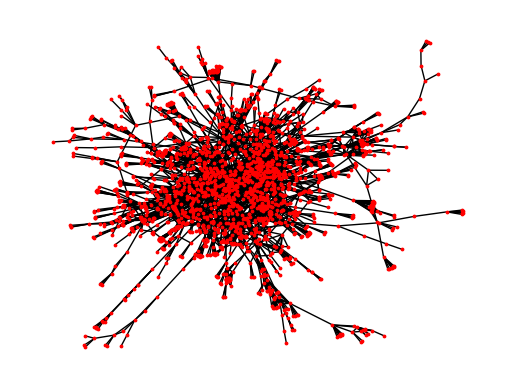

In [68]:
subax1 = plt.subplot()
nx.draw(author_network, **options)

- For convenience, in the following, we call this giant component "the author network".

### Generating Random Network